In [48]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import scipy.special as special
import pandas as pd
import chaospy as cp
import pyDOE

%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns

sns.set_style("ticks")#'whitegrid')#
#sns.set_context("talk")
sns.set_style({'axes.linewidth':0.5,
               'xtick.direction': u'in',
               'xtick.major.size': 1.,
               'xtick.minor.size': 0.5,
               'ytick.direction': u'in',               
               'ytick.major.size': 1.,
               'ytick.minor.size': 0.5})  

from scipy.stats import weibull_min
from scipy.special import gamma

Uniform distribued: $x1$ and $x2$

In [49]:
k_true = 2.
A_true = 8.
dist = cp.Weibull(shape=k_true, scale=A_true, shift=0)

### a) MC sample

A full Monte-Carlo simulation of the inputs is done ussing a reduced variance sampling method.

"K"     Korobov             
"R"     (Pseudo-)Random     
"L"     Latin hypercube     
"S"     Sobol               
"H"     Halton              
"M"     Hammersley          

The input sample is propagated through the model

In [50]:
np.random.seed(1)
N = 100
rule='R'
sample_inputs = dist.sample(size=N,rule=rule)
k_hat, _, A_hat = stats.weibull_min.fit(sample_inputs,floc=0.)

N = int(1e3)
rule='R'
sample_inputs_b = dist.sample(size=N,rule=rule)
k_hat_b, _, A_hat_b = stats.weibull_min.fit(sample_inputs_b,floc=0.)

N = int(1e4)
rule='R'
sample_inputs_c = dist.sample(size=N,rule=rule)
k_hat_c, _, A_hat_c = stats.weibull_min.fit(sample_inputs_c,floc=0.)

In [51]:
sample = sample_inputs_c
x_ws = np.linspace(0,35,100)

#### a) Mean and Variance Based Weibull Fit

Iterativelly fit the weibull function based on the mean and variance

- Expected: $\mathbb{E}(x) = A \, \left[ \Gamma \left(1 + \dfrac{1}{k} \right) \right]$
- Variance: $\mathbb{V}(x) = A^2 \, \left[ \Gamma \left(1 + \dfrac{2}{k} \right) - \Gamma^2 \left(1 + \dfrac{1}{k} \right) \right]$

In order to implement this method, the squared error (SE) in the mean and variance estimations are used as error function to be minimized.

In [52]:
def weibull_EV(x,E,V):
    A=x[0]; k=x[1]
    out=[0,0]
    out[0] = ( A*gamma(1.0+1.0/k) - E )**2.0
    out[1] = ( A**2*( gamma(1.0+2.0/k) - (gamma(1.0+1.0/k))**2.0 ) - V )**2.0
    return out

In [53]:
E = np.mean(sample_inputs)
V = np.var(sample_inputs)
A_EV,k_EV = sp.optimize.fsolve(weibull_EV, [10,2],args=(E,V), xtol=1e-6, maxfev=10000)
print '-------------------------'
print 'Mean and variance error'
print '-------------------------'
print
print 'Shape, k\t'+'Scale, A'
print '[-]\t\t'+'[m/s]\t\t'
print '-------------------------'
print '%0.4f\t\t%0.4f\t\t' % (k_EV, A_EV)
print
print 'mean-SE\t\t'+'Var-SE'
print '[m/s]^2\t\t'+'[m/s]^4\t\t'
print '-------------------------'
print '%0.2e\t%0.2e\t\t' % (weibull_EV([A_EV,k_EV],E,V)[0],weibull_EV([A_EV,k_EV],E,V)[1])

pdf_ws_EV_fit = weibull_min.pdf(x_ws, c=k_EV, scale=A_EV)

-------------------------
Mean and variance error
-------------------------

Shape, k	Scale, A
[-]		[m/s]		
-------------------------
1.9550		7.7517		

mean-SE		Var-SE
[m/s]^2		[m/s]^4		
-------------------------
1.72e-15	3.47e-13		


#### b) Mean and Skewness Based Weibull Fit

Iterativelly fit the weibull function based on the mean and variance

- Expected: $\mathbb{E}(x) = A \, \left[ \Gamma \left(1 + \dfrac{1}{k} \right) \right]$
- Variance: $\mathbb{V}(x) = A^2 \, \left[ \Gamma \left(1 + \dfrac{2}{k} \right) - \Gamma^2 \left(1 + \dfrac{1}{k} \right) \right]$
- Skewness: $\mathbb{S}(x) = \dfrac{ A^3 \, \left[ \Gamma \left(1 + \dfrac{3}{k} \right) \right] - 3 \,\mathbb{E} \, \mathbb{V} - \mathbb{E}^3 }{\sigma^3}$

In order to implement this method, the squared error (SE) in the mean and skewness estimations are used as error function to be minimized.



In [54]:
def weibull_EVSk(x,E,V,Sk):
    A=x[0]; k=x[1]
    out=[0,0]
    out[0] = ( A*gamma(1+1/k) - E )**2
    out[1] = ( (A**3.0*gamma(1+3/k) - 3.0*E*( A**2*( gamma(1.0+2.0/k) - (gamma(1.0+1.0/k))**2.0 ) ) - E**3.0)/( A**2*( gamma(1.0+2.0/k) - (gamma(1.0+1.0/k))**2.0 ) )**1.5 - Sk )**2.0
    return out

In [55]:
E = np.mean(sample_inputs)
V = np.var(sample_inputs)
Sk = stats.skew(sample_inputs)
A_EVSk, k_EVSk = sp.optimize.fsolve(weibull_EVSk, [10,2],args=(E,V,Sk), xtol=1e-6, maxfev=1000)
print '-------------------------'
print 'Mean and Skewness error'
print '-------------------------'
print
print 'Shape, k\t'+'Scale, A'
print '[-]\t\t'+'[m/s]\t\t'
print '-------------------------'
print '%0.4f\t\t%0.4f\t\t' % (k_EVSk, A_EVSk)
print
print 'mean-SE\t\t'+'Sk-SE'
print '[m/s]^2\t\t'+'[-]\t\t'
print '-------------------------'
print '%0.2e\t%0.2e\t\t' % (weibull_EVSk([A_EVSk,k_EVSk],E,V,Sk)[0],weibull_EVSk([A_EVSk,k_EVSk],E,V,Sk)[1])

pdf_ws_EVSk_fit = weibull_min.pdf(x_ws, c=k_EVSk, scale=A_EVSk)

-------------------------
Mean and Skewness error
-------------------------

Shape, k	Scale, A
[-]		[m/s]		
-------------------------
2.3615		7.7554		

mean-SE		Sk-SE
[m/s]^2		[-]		
-------------------------
4.03e-19	5.31e-17		


#### d) Maximum Likelihood Estimation (MLE)

MLE estimation consist in finding the distribution parameters $A$ and $k$, that maximize the likelihood function. This function is the probability of observing a measurement given a set of parameters, which means that it takes the same values as the PDF. 

$\mathcal{L}(A,k|y) = \text{PDF}(y|A,k)$

The maximum likelihood estimation method consist in finding the parameters that maximize the total likelihood of all the measurements. This method is the most computationally demanding due to the need to evaluate the likelihood function for each observation while varying the shape and scale parameters  of the Weibull function.

In [56]:
#k_MLE,loc,A_MLE= weibull_min.fit(sample_inputs,floc=0,shape=2,scale=10)
k_MLE,loc,A_MLE= stats.weibull_min.fit(sample_inputs_c,floc=0.)

In [57]:
print 'Shape, k\t'+'Scale, A'
print '[-]\t\t'+'[m/s]\t\t'
print '-------------------------'
print '%0.4f\t\t%0.4f\t\t' % (k_MLE,A_MLE)

pdf_ws_MLE_fit = weibull_min.pdf(x_ws, c=k_MLE, scale=A_MLE)

Shape, k	Scale, A
[-]		[m/s]		
-------------------------
2.0139		7.9657		


In [58]:
def fformat(f, prec=2):
    s = "%.*f"%(prec, f)
    # add 1 to digits as 1 is taken by sign +/-
    return ' '+"%s"%(s)

In [59]:
df = pd.DataFrame(columns=['True','EV','ESk','MLE'],
             index=['A','k'],
             data=np.array([[A_true,A_EV,A_EVSk,A_MLE],[k_true,k_EV,k_EVSk,k_MLE]]))

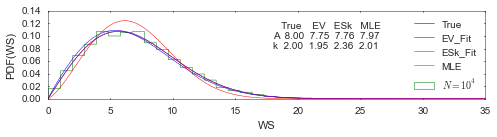

In [62]:
fig = plt.figure(figsize=[7,2])
ax = fig.add_subplot(1,1,1)

x_plot = np.linspace(0,35,500)
ax.plot(x_plot,dist.pdf(x_plot),'-k',lw=0.5,label='True')

bins=25

ax.hist(sample_inputs_c,
        bins=bins,#np.linspace(-0.2,.2,50),
        histtype='step',
        color='green',
        lw=0.5,
        normed=True,
        cumulative=False,
        label=r'$N=10^4$')

plt.plot(x_ws,pdf_ws_EV_fit,'-b',lw=0.5,label='EV_Fit')
plt.plot(x_ws,pdf_ws_EVSk_fit,'-r',lw=0.5,label='ESk_Fit')
plt.plot(x_ws,pdf_ws_MLE_fit,'-m',lw=0.5,label='MLE')

ax.annotate(df.to_string(col_space=0,justify='right',float_format =fformat),(18,0.08))

ax.set_xlabel('WS')
ax.set_ylabel('PDF(WS)')
ax.legend(loc='upper right')

fig.tight_layout()
fig.savefig('Figures/0_Statistical_Uncertainty_Method.pdf')